In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Chargement des données

- `X_train` et `X_test` ont  $35$ colonnes qui représentent les même variables explicatives mais sur des périodes de temps différentes. 

- `X_train` et `Y_train` partagent la même colonne `ID` - chaque ligne a un ID unique associé à un jour et à un pays. 

- La variable cible `TARGET` de `Y_train` correspond à la variation de prix journalière des futures sur l'électricité (maturité 24h).

- **On notera que certaines colonnes ont des valeurs manquantes**.

In [6]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [10]:
# Code pour réaliser un one hot encoder : permet d'améliorer la performance ici
X_train = pd.get_dummies(X_train, columns=["COUNTRY"])
X_test = pd.get_dummies(X_test, columns=["COUNTRY"])

In [16]:
#on complète avec des 0, puis on on drop l'id
X_train_ssID = X_train.drop(['ID', 'DAY_ID'], axis=1).fillna(0)
Y_train_ssID = Y_train.drop(['ID'], axis=1).fillna(0)

In [36]:
##créons un dataframe qui contiennent variables et target
X_Y_train = pd.merge(X_train, Y_train, on=['ID'])
X_Y_train_ssID = X_Y_train.drop(['ID', 'DAY_ID'], axis=1).fillna(0)

## Imports des modèles pour enlever les outliers

On va enlever les outliers avec ECOD, ABOD, CBLOF

In [3]:
import pyod

In [5]:
from pyod.models.ecod import ECOD
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF

In [7]:
#outliers_fraction
outliers_fraction = 0.05

In [38]:
X_train_ssID.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
0,0.210099,-0.427458,-0.606523,0.606523,0.000000,0.692860,0.000000,-0.692860,0.441238,-0.213766,...,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0,1
1,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,...,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,0,1
2,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,...,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,0,1
3,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,...,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,1,0
4,0.143807,-0.617038,-0.924990,0.924990,0.000000,0.990324,0.000000,-0.990324,0.238693,-0.240862,...,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,0,1


### seulement sur les variables

In [31]:
abod_clf = ABOD(contamination=outliers_fraction)
abod_clf.fit(np.array(X_train_ssID), None )

In [30]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False)
cblof_clf.fit(np.array(X_train_ssID), None )


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=None, random_state=None,
   use_weights=False)

In [29]:
cblof_ecd = ECOD(contamination=0.05)
cblof_ecd.fit(np.array(X_train_ssID),None)

ECOD(contamination=0.05, n_jobs=1)

In [ ]:
df['ABOD_Clf'] = abod_clf.labels_
df['CBLOF_Clf'] = cblof_clf.labels_

### sur les variables et la target

In [46]:
X_Y_train_ssID.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,TARGET
0,0.210099,-0.427458,-0.606523,0.606523,0.000000,0.692860,0.000000,-0.692860,0.441238,-0.213766,...,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0,1,0.028313
1,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,...,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,0,1,-0.112516
2,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,...,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,0,1,-0.180840
3,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,...,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,1,0,-0.260356
4,0.143807,-0.617038,-0.924990,0.924990,0.000000,0.990324,0.000000,-0.990324,0.238693,-0.240862,...,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,0,1,-0.071733


In [47]:
abod_clf = ABOD(contamination=outliers_fraction)
abod_clf.fit(np.array(X_Y_train_ssID) )

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [48]:
abod_clf.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False)
cblof_clf.fit(np.array(X_Y_train_ssID))

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=None, random_state=None,
   use_weights=False)

In [50]:
cblof_clf.labels_

array([0, 0, 0, ..., 0, 1, 0])

In [51]:
ecod_clf = ECOD(contamination=0.05)
ecod_clf.fit(np.array(X_Y_train_ssID))

ECOD(contamination=0.05, n_jobs=1)

In [59]:
ecod_clf.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
abod_clf.labels_.shape[0] - np.sum(abod_clf.labels_ == ecod_clf.labels_)

122

122 points où ils ne sont pas d'accord sur l'identification de l'outlier.

In [60]:
print("Le nombre d'outliers détectés par les méthodes de ABOD, ECOD, CBLOF est",
      np.sum(abod_clf.labels_),np.sum(ecod_clf.labels_), np.sum(cblof_clf.labels_) )
print("C'est normal car on a demandé 5% d'outlier, 0.05*1494 = 75")

print("\n\nLe nombre de labelisations différentes entre ABOD et ECOD", 
      abod_clf.labels_.shape[0] - np.sum(abod_clf.labels_ == ecod_clf.labels_))

print("\nLe nombre de labelisations différentes entre ABOD et CBLOF", 
      abod_clf.labels_.shape[0] - np.sum(abod_clf.labels_ == cblof_clf.labels_))

print("\nLe nombre de labelisations différentes entre ECOD et CBLOF", 
      abod_clf.labels_.shape[0] - np.sum(ecod_clf.labels_ == cblof_clf.labels_))



Le nombre d'outliers détectés par les méthodes de ABOD, ECOD, CBLOF est 75 75 75
C'est normal car on a demandé 5% d'outlier, 0.05*1494 = 75


Le nombre de labelisations différentes entre ABOD et ECOD 122

Le nombre de labelisations différentes entre ABOD et CBLOF 88

Le nombre de labelisations différentes entre ECOD et CBLOF 90


Text(0.5, 1.0, 'CBLOF')

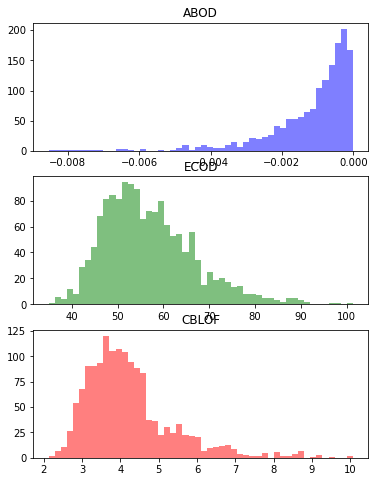

In [65]:
import matplotlib.pyplot as plt

# Créer une figure avec 3 sous-figures
fig, axs = plt.subplots(3, 1, figsize=(6, 8))

# Créer les histogrammes pour chaque sous-figure
axs[0].hist(abod_clf.decision_scores_, bins=50, color='blue', alpha=0.5)
axs[1].hist(ecod_clf.decision_scores_, bins=50, color='green', alpha=0.5)
axs[2].hist(cblof_clf.decision_scores_, bins=50, color='red', alpha=0.5)

# Ajouter des titres et des étiquettes aux axes
axs[0].set_title('ABOD')
axs[1].set_title('ECOD')
axs[2].set_title('CBLOF')

In [76]:
###on va rechercher le meilleur pourcentage d'outlier,
##pour ce faire on va parcourir toutes les outlier_fraction de 0 à 8 et prendre 40 points
scores=[]
fractions = np.linspace(0.001,0.5,40)

for outlier_fraction in fractions :
    abod_clf = ABOD(contamination=outlier_fraction)
    abod_clf.fit(np.array(X_Y_train_ssID) )
    
    cblof_clf = CBLOF(contamination=outlier_fraction,check_estimator=False)
    cblof_clf.fit(np.array(X_Y_train_ssID))
    
    ecod_clf = ECOD(contamination=outlier_fraction)
    ecod_clf.fit(np.array(X_Y_train_ssID))
    
   
    ABOD_ECOD =  abod_clf.labels_.shape[0] - np.sum(abod_clf.labels_ == ecod_clf.labels_)
    ABOD_CBLOF =  abod_clf.labels_.shape[0] - np.sum(abod_clf.labels_ == cblof_clf.labels_)
    ECOD_CBLOF =  abod_clf.labels_.shape[0] - np.sum(ecod_clf.labels_ == cblof_clf.labels_)
    #print(np.sum(cblof_clf.labels_))
    score = (ABOD_ECOD+ABOD_CBLOF+ECOD_CBLOF)/(3*np.sum(cblof_clf.labels_))
    scores.append(score)
    

Text(0.5, 1.0, "Scores en fonction du pourcentage d'outliers")

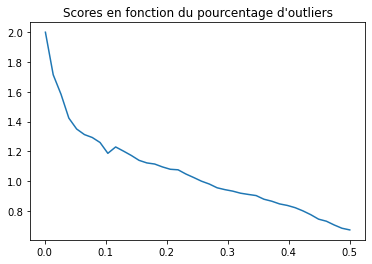

In [75]:
plt.plot(fractions, scores)
plt.title("Scores en fonction du pourcentage d'outliers")

## Linear Regression Sans Outliers

In [96]:
# Split du Dataset
# Attention au split qui ne prend pas en compte la chronologie de la data : les ordonner avant de split ?
from sklearn.model_selection import train_test_split

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, Y_train, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [101]:
X_test_split_clean = X_test_split.drop(['ID', 'DAY_ID'], axis=1).fillna(0)

In [102]:
data_train_split= pd.merge(X_train_split, y_train_split, on = ['ID']).drop(['ID', 'DAY_ID'], axis=1).fillna(0)

data_test_split = pd.merge(X_test_split, y_test_split, on = ['ID']).drop(['ID', 'DAY_ID'], axis=1).fillna(0)

In [103]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False)
cblof_clf.fit(data_train_split)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=None, random_state=None,
   use_weights=False)

In [104]:
data_clean = data_train_split.iloc[np.where(cblof_clf.labels_==False)[0]]

In [109]:
data_clean

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,TARGET
0,0.887536,0.458947,0.187241,-0.187241,-0.306899,-0.132897,0.306899,0.132897,2.002031,1.077058,...,0.000000,0.000000,0.000000,0.000000,0.297234,0.172894,0.218442,0,1,-0.143463
1,1.094086,0.682399,-0.652040,0.652040,0.210913,0.784182,-0.210913,-0.784182,1.463603,1.253415,...,0.000000,0.000000,0.000000,0.000000,1.026604,0.940184,0.307300,0,1,-0.197998
2,0.840833,0.502048,-0.269059,0.269059,0.354680,0.448054,-0.354680,-0.448054,1.151507,1.104127,...,-0.782648,-0.091823,0.682097,0.118065,1.305656,1.522940,1.256574,0,1,0.054675
3,0.241260,-0.724728,-1.332251,1.332251,-1.267757,0.877023,1.267757,-0.877023,0.303140,-0.182718,...,-0.661079,-0.860775,1.556207,0.324603,-1.285317,-0.990099,-0.345532,0,1,0.058881
4,0.649475,-0.092046,-0.463234,0.463234,-0.240366,-0.175779,0.240366,0.175779,1.973318,0.515358,...,-0.903382,-0.488872,0.379985,-0.537956,-0.932351,-1.448664,-0.195000,1,0,-0.353890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,0.862662,0.057560,0.507794,-0.507794,0.991940,0.640973,-0.991940,-0.640973,0.270689,0.974641,...,-0.189836,-0.108926,0.996129,1.019857,0.409330,1.399861,0.369472,0,1,-0.192353
1191,1.017589,1.095426,-1.147988,1.147988,-0.325986,0.826487,0.325986,-0.826487,1.624622,1.539692,...,-0.660718,-0.238744,0.010743,0.608786,0.852829,-0.042812,-0.260673,0,1,-0.020178
1192,1.428743,0.934636,-0.449670,0.449670,0.583453,0.140900,-0.583453,-0.140900,1.136642,1.057465,...,0.000000,0.000000,0.000000,0.000000,-0.380672,-0.752106,-0.212513,1,0,-0.236414
1193,0.651926,-0.329341,0.103032,-0.103032,0.052131,0.341087,-0.052131,-0.341087,-0.183239,-0.080466,...,0.329869,0.545885,-0.894588,-0.730405,3.155879,0.601560,-0.523791,1,0,-0.829869


In [111]:
data_clean['TARGET']

0      -0.143463
1      -0.197998
2       0.054675
3       0.058881
4      -0.353890
          ...   
1190   -0.192353
1191   -0.020178
1192   -0.236414
1193   -0.829869
1194    0.279534
Name: TARGET, Length: 1135, dtype: float64

In [107]:
# Linear Regression sur notre X_train_split et Y_train_split

lr_split = LinearRegression()

lr_split.fit(data_clean.drop(['TARGET'], axis=1), data_clean['TARGET'])

output_split = lr_split.predict(X_test_split_clean)

def metric_train(output):

    return  spearmanr(output, y_test_split).correlation

# On vérifie que notre split repdroduit bien le benchmark : on désire retrouver une Corrélation de 15.9 % sur y_test_split

print("Corrélation (Spearman) pour les données d'entrainement Regression linéaire : {:.1f}%".format(100 * metric_train(output_split) ))

TypeError: unsupported format string passed to numpy.ndarray.__format__